## Import Packages

In [1]:
import cv2
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import time
import cv2
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import pickle
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load Images

In [2]:
# Load images first
numImages = len(glob.glob('./images/*jpg'))
images = [None for i in xrange(numImages)]
for fileName in glob.glob('./images/*jpg'):
    fileNum = int(fileName[9:][:-4])
    images[fileNum-1] = np.array(cv2.imread(fileName))
images = np.array(images)

# Load csv data next
train_data = pd.read_csv('data/train.csv').drop(['species'], axis=1).values
train_labels = pd.read_csv('data/train.csv')['species'].values
labels=train_labels.tolist()
train_images = [images[int(data[0]-1)] for data in train_data]
train_ids = [data[0] for data in train_data]
train_data = np.delete(train_data, 0, 1)


test_data = pd.read_csv('data/test.csv').values
test_images = [images[int(data[0]-1)] for data in test_data]
test_ids = [data[0] for data in test_data]
test_data = np.delete(test_data, 0, 1)

del images

## Define Image Normalization and Mini-Batch

In [3]:
#CNN train data
def img_norm(img):
    t= 2 * (np.float32(img) / 255 - 0.5) # normalize img pixels to [-1, 1]
    return t
def minibatchData(data,labels_encoded,img_size,channel_num=3,batch_num=30):
    images=[]
    for img in data:
        images.append(np.transpose(img_norm(cv2.resize(img,img_size)),[2,0,1]))
    
    
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(images))
        print(batch_num)
        
        for i in range(int(len(images) / batch_num)):
            minibatch_d = images[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num,img_size[0],img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))
            if labels_encoded is not None:
                minibatch_l = labels_encoded[i*batch_num: (i+1)*batch_num]
                batch_labels.append(torch.LongTensor(minibatch_l))
            else:
                minibatch_l = np.zeros(batch_num)
                batch_labels.append(torch.LongTensor(minibatch_l))
        #data, labels = batch_data, batch_labels 
        
    return zip(batch_data, batch_labels)

## Prepare image label encodings

In [4]:
le= preprocessing.LabelEncoder()
#encode train labels
le.fit(train_labels)
train_labels_encoded=le.transform(train_labels)

In [5]:
img_size=(224,224)
cnn_train_data = list(minibatchData(train_images,train_labels_encoded,img_size))
#plt.imshow(cnn_train_data[0][0][3][0])

990
30


594
2


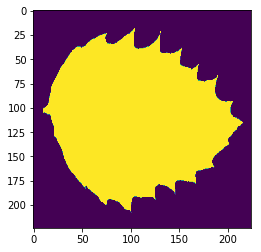

In [6]:
cnn_test_data = list(minibatchData(test_images,None,img_size,batch_num=2))
#print cnn_train_data.size
plt.imshow(cnn_test_data[0][0][1][0])

## Load saved alexnet from file

In [7]:
filename='tunedAlex.sav'
model_ft = pickle.load(open(filename,'rb'))

## Generate the CNN Train data

In [8]:
probs_cnn_train=np.empty([0,99])
#sm = torch.nn.Softmax()
for data in cnn_train_data:
    images,labels=data
    probs_cnn_train=np.append(probs_cnn_train,(model_ft(images)).data.numpy(),axis=0)
print probs_cnn_train.shape
    

(990, 99)


## Generate the CNN Test data

In [9]:
probs_cnn_test=np.empty([0,99])
for data in cnn_test_data:
    images, labels = data
    probs_cnn_test=np.append(probs_cnn_test,(model_ft(images)).data.numpy(),axis=0)
    #outputs=np.append(outputs,net(images).data.numpy(),axis=0)
    #print probs
    

print probs_cnn_test.shape

#sm = torch.nn.Softmax()
#probabilities = sm(output) 
#print(probabilities)

(594, 99)


## Generate the test/train logical partitions

In [10]:
#separate the 3 histograms
train_margin_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'margin1':'margin64']).values
train_shape_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'shape1':'shape64']).values
train_texture_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'texture1':'texture64']).values

In [11]:
test_margin_data=((pd.read_csv('data/test.csv')).loc[:,'margin1':'margin64']).values
test_shape_data=((pd.read_csv('data/test.csv')).loc[:,'shape1':'shape64']).values
test_texture_data=((pd.read_csv('data/test.csv')).loc[:,'texture1':'texture64']).values

#print train_margin_data.head()
#print train_shape_data.head()
#print train_texture_data.head()

In [12]:
def get_descriptor(images, dense=False):
    sift = cv2.xfeatures2d.SIFT_create()
    des_per_Img = np.array([sift.detectAndCompute(img,None)[1] for img in images])
    return des_per_Img
        
def get_clusters(descriptors, vocabSize):
    des_list = np.concatenate(descriptors)

    kmeans = MiniBatchKMeans(vocabSize, batch_size=100)
    kmeans.fit(np.array(des_list))
    
    return kmeans

def get_vocabulary(descriptors, clusters, vocabSize):
    return np.array([normalize(np.histogram(clusters.predict(dscrs), bins=range(vocabSize))[0].reshape(1,-1)).ravel() for dscrs in descriptors])
        

In [13]:
des_start_time =time.time()
des_list_train = get_descriptor(train_images)

des_list_test = get_descriptor(test_images)
des_end_time =time.time()
print "Descriptors computed in {:2f} seconds".format(des_end_time-des_start_time)

Descriptors computed in 133.268115 seconds


In [14]:
clustering_start_time=time.time()
clusters = get_clusters(des_list_train,150)
clustering_end_time=time.time()
print "Clustering completed in {:2f} seconds".format(clustering_end_time-clustering_start_time)

Clustering completed in 2.823910 seconds


In [15]:
vocab_train = get_vocabulary(des_list_train,clusters,150)
vocab_test = get_vocabulary(des_list_test,clusters,150)

print vocab_train.shape

(990, 149)


## Build the weak learners as Keras Neural Networks

In [93]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.utils import np_utils
import keras

In [94]:
deep_shape = Sequential([Dense(256, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dense(99, activation='softmax')])
deep_texture = Sequential([Dense(256, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dense(99, activation='softmax')])
deep_margin = Sequential([Dense(256, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dense(99, activation='softmax')])
deep_sift = Sequential([Dense(256, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dense(99, activation='softmax')])
deep_alex = Sequential([Dense(256, activation='relu'), Dropout(0.5), Dense(128, activation='relu'), Dense(99, activation='softmax')])

In [95]:
deep_shape.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])
deep_texture.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])
deep_margin.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])
deep_sift.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])
deep_alex.compile(loss='categorical_crossentropy', optimizer='adam', metric=[keras.metrics.categorical_accuracy])

In [96]:
deep_alex.fit(probs_cnn_train,Y_labels,batch_size=16,epochs=150)
deep_shape.fit(train_shape_data,Y_labels,batch_size=16,epochs=150)
deep_texture.fit(train_texture_data,Y_labels,batch_size=16,epochs=150)
deep_margin.fit(train_margin_data,Y_labels,batch_size=16,epochs=150)
deep_sift.fit(vocab_train,Y_labels,batch_size=16,epochs=150)


deep_input = np.array(deep_shape.predict(train_shape_data))
deep_input = np.array(np.append(deep_input, deep_texture.predict(train_texture_data), axis=1))
deep_input = np.array(np.append(deep_input, deep_margin.predict(train_margin_data), axis=1))
deep_input = np.array(np.append(deep_input, deep_sift.predict(vocab_train), axis=1))
deep_input = np.array(np.append(deep_input, deep_alex.predict(probs_cnn_train), axis=1))




# deep_final.fit(deep_input,Y_labels,batch_size=16,epochs=50)


Epoch 1/150
990/990 [==============================] - 2s 2ms/step - loss: 5.0129
Epoch 2/150
990/990 [==============================] - 0s 316us/step - loss: 2.6516
Epoch 3/150
990/990 [==============================] - 0s 316us/step - loss: 1.5004
Epoch 4/150
990/990 [==============================] - 0s 316us/step - loss: 1.0199
Epoch 5/150
990/990 [==============================] - 0s 326us/step - loss: 0.7763
Epoch 6/150
990/990 [==============================] - 0s 313us/step - loss: 0.5943
Epoch 7/150
990/990 [==============================] - 0s 314us/step - loss: 0.5314
Epoch 8/150
990/990 [==============================] - 0s 333us/step - loss: 0.4401
Epoch 9/150
990/990 [==============================] - 0s 316us/step - loss: 0.3728
Epoch 10/150
990/990 [==============================] - 0s 314us/step - loss: 0.3075
Epoch 11/150
990/990 [==============================] - 0s 348us/step - loss: 0.3162
Epoch 12/150
990/990 [==============================] - 0s 450us/step - loss

990/990 [==============================] - 0s 313us/step - loss: 3.9127
Epoch 44/150
990/990 [==============================] - 0s 344us/step - loss: 3.9198
Epoch 45/150
990/990 [==============================] - 0s 309us/step - loss: 3.9032
Epoch 46/150
990/990 [==============================] - 0s 308us/step - loss: 3.8993
Epoch 47/150
990/990 [==============================] - 0s 318us/step - loss: 3.8924
Epoch 48/150
990/990 [==============================] - 0s 306us/step - loss: 3.8783
Epoch 49/150
990/990 [==============================] - 0s 306us/step - loss: 3.8554
Epoch 50/150
990/990 [==============================] - 0s 307us/step - loss: 3.8529
Epoch 51/150
990/990 [==============================] - 0s 314us/step - loss: 3.8783
Epoch 52/150
990/990 [==============================] - 0s 307us/step - loss: 3.8512
Epoch 53/150
990/990 [==============================] - 0s 311us/step - loss: 3.8210
Epoch 54/150
990/990 [==============================] - 0s 320us/step - loss: 

990/990 [==============================] - 0s 324us/step - loss: 3.6289
Epoch 140/150
990/990 [==============================] - 0s 322us/step - loss: 3.6085
Epoch 141/150
990/990 [==============================] - 0s 304us/step - loss: 3.6070
Epoch 142/150
990/990 [==============================] - 0s 308us/step - loss: 3.6243
Epoch 143/150
990/990 [==============================] - 0s 316us/step - loss: 3.6181 0s - loss: 3.6
Epoch 144/150
990/990 [==============================] - 0s 308us/step - loss: 3.6134
Epoch 145/150
990/990 [==============================] - 0s 310us/step - loss: 3.6229
Epoch 146/150
990/990 [==============================] - 0s 318us/step - loss: 3.6321
Epoch 147/150
990/990 [==============================] - 0s 309us/step - loss: 3.6675
Epoch 148/150
990/990 [==============================] - 0s 310us/step - loss: 3.5987
Epoch 149/150
990/990 [==============================] - 0s 308us/step - loss: 3.6486
Epoch 150/150
990/990 [==============================

990/990 [==============================] - 0s 376us/step - loss: 1.0961
Epoch 32/150
990/990 [==============================] - 0s 407us/step - loss: 1.0997
Epoch 33/150
990/990 [==============================] - 0s 443us/step - loss: 1.0685
Epoch 34/150
990/990 [==============================] - 0s 412us/step - loss: 1.0235
Epoch 35/150
990/990 [==============================] - 0s 448us/step - loss: 1.0014
Epoch 36/150
990/990 [==============================] - 0s 467us/step - loss: 1.0066
Epoch 37/150
990/990 [==============================] - 0s 335us/step - loss: 1.0082
Epoch 38/150
990/990 [==============================] - 0s 371us/step - loss: 0.9941
Epoch 39/150
990/990 [==============================] - 0s 415us/step - loss: 0.9854
Epoch 40/150
990/990 [==============================] - 0s 384us/step - loss: 0.9927
Epoch 41/150
990/990 [==============================] - 0s 390us/step - loss: 0.9746
Epoch 42/150
990/990 [==============================] - 0s 365us/step - loss: 

990/990 [==============================] - 0s 347us/step - loss: 0.1239
Epoch 74/150
990/990 [==============================] - 0s 345us/step - loss: 0.1372
Epoch 75/150
990/990 [==============================] - 0s 366us/step - loss: 0.1290
Epoch 76/150
990/990 [==============================] - 0s 348us/step - loss: 0.1152
Epoch 77/150
990/990 [==============================] - 0s 346us/step - loss: 0.1107
Epoch 78/150
990/990 [==============================] - 0s 356us/step - loss: 0.1060
Epoch 79/150
990/990 [==============================] - 0s 348us/step - loss: 0.1004
Epoch 80/150
990/990 [==============================] - 0s 346us/step - loss: 0.1001
Epoch 81/150
990/990 [==============================] - 0s 359us/step - loss: 0.0890
Epoch 82/150
990/990 [==============================] - 0s 344us/step - loss: 0.0904
Epoch 83/150
990/990 [==============================] - 0s 344us/step - loss: 0.1044
Epoch 84/150
990/990 [==============================] - 0s 357us/step - loss: 

## Build, Train, and Test the Strong Learner 

In [160]:
# deep_model = Sequential([
#     Dense(512, activation='relu'),
#     Dense(1024, activation='relu'),
#     Dropout(0.4),
#     Dense(256, activation='relu'),
#     Dense(99, activation='softmax')
# ])

deep_model = Sequential([
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(99, activation='softmax')
])

deep_model.compile(loss='categorical_crossentropy',optimizer='adam',metric=[keras.metrics.categorical_accuracy])

In [171]:
# deep_input=np.array(np.append(train_margin_data,train_texture_data,axis=1))
# deep_input=np.array(np.append(deep_input,train_shape_data,axis=1))
# deep_input=np.array(np.append(deep_input,vocab_train,axis=1))
# deep_input=np.array(np.append(deep_input,probs_cnn_train,axis=1))
# Y_labels = np_utils.to_categorical(train_labels_encoded,99)
# print deep_input.shape
deep_model.summary()
deep_model.layers.pop()
deep_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 512)               253952    
_________________________________________________________________
dense_139 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_64 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_140 (Dense)            (None, 99)                50787     
Total params: 567,395
Trainable params: 567,395
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 512)               253952    
_________________________________________________________________
dens

In [162]:
deep_model.fit(deep_input,Y_labels,batch_size=32,epochs=200, validation_split=0.2)
deep_model.summary()

Train on 792 samples, validate on 198 samples
Epoch 1/200
792/792 [==============================] - 3s 4ms/step - loss: 4.1966 - val_loss: 3.5697
Epoch 2/200
792/792 [==============================] - 0s 631us/step - loss: 2.3057 - val_loss: 1.2145
Epoch 3/200
792/792 [==============================] - 0s 592us/step - loss: 0.2929 - val_loss: 0.0786
Epoch 4/200
792/792 [==============================] - 0s 615us/step - loss: 0.0246 - val_loss: 0.0143
Epoch 5/200
792/792 [==============================] - 0s 580us/step - loss: 0.0107 - val_loss: 0.0091
Epoch 6/200
792/792 [==============================] - 0s 582us/step - loss: 0.0069 - val_loss: 0.0070
Epoch 7/200
792/792 [==============================] - 0s 613us/step - loss: 0.0056 - val_loss: 0.0054
Epoch 8/200
792/792 [==============================] - 0s 580us/step - loss: 0.0048 - val_loss: 0.0044
Epoch 9/200
792/792 [==============================] - 0s 596us/step - loss: 0.0036 - val_loss: 0.0037
Epoch 10/200
792/792 [=======

Epoch 148/200
792/792 [==============================] - 1s 697us/step - loss: 1.9372e-05 - val_loss: 1.5208e-05
Epoch 149/200
792/792 [==============================] - 1s 722us/step - loss: 1.7274e-05 - val_loss: 1.4969e-05
Epoch 150/200
792/792 [==============================] - 1s 676us/step - loss: 1.9074e-05 - val_loss: 1.4727e-05
Epoch 151/200
792/792 [==============================] - 1s 790us/step - loss: 1.5969e-05 - val_loss: 1.4440e-05
Epoch 152/200
792/792 [==============================] - 1s 724us/step - loss: 1.7297e-05 - val_loss: 1.4143e-05
Epoch 153/200
792/792 [==============================] - 1s 701us/step - loss: 1.7070e-05 - val_loss: 1.3866e-05
Epoch 154/200
792/792 [==============================] - 1s 674us/step - loss: 1.8028e-05 - val_loss: 1.3621e-05
Epoch 155/200
792/792 [==============================] - 1s 732us/step - loss: 1.6242e-05 - val_loss: 1.3365e-05
Epoch 156/200
792/792 [==============================] - 1s 662us/step - loss: 1.6186e-05 - val_

In [163]:
# deep_input = np.array(deep_shape.predict(train_shape_data))
# deep_input = np.array(np.append(deep_input, deep_texture.predict(train_texture_data), axis=1))
# deep_input = np.array(np.append(deep_input, deep_margin.predict(train_margin_data), axis=1))
# deep_input = np.array(np.append(deep_input, deep_sift.predict(vocab_train), axis=1))
# deep_input = np.array(np.append(deep_input, deep_alex.predict(probs_cnn_train), axis=1))




## Prepare the output for the Kaggle Submission

In [164]:
deep_input_test = np.array(deep_shape.predict(test_shape_data))
deep_input_test = np.array(np.append(deep_input_test, deep_texture.predict(test_texture_data), axis=1))
deep_input_test = np.array(np.append(deep_input_test, deep_margin.predict(test_margin_data), axis=1))
deep_input_test = np.array(np.append(deep_input_test, deep_sift.predict(vocab_test), axis=1))
deep_input_test = np.array(np.append(deep_input_test, deep_alex.predict(probs_cnn_test), axis=1))


out_file = deep_model.predict(deep_input_test)
out_file = np.append(np.array(test_ids).reshape(-1,1),out_file,axis=1)

In [165]:
# out_file = generateSubmission(test_ids, test_data,svm_model,99)
headerRow=np.array(['id'] + le.inverse_transform(range(99)).tolist())
df = pd.DataFrame(data=out_file, columns = headerRow)
df['id'] = df['id'].astype(np.int)
df=df.set_index('id')
#print df.head()
# np.set_printoptions(threshold=np.inf)
# print out_file
df.to_csv('output/28_11_18_013(ALexNet15Deep).csv')

/Users/anishsaha/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
